# [Invasive Species Monitoring](https://www.kaggle.com/c/invasive-species-monitoring)

### Imports

In [1]:
import cv2
import numpy as np
import pandas as pd
from random import shuffle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn import metrics
from PIL import Image
import pickle

from mpl_toolkits.axes_grid1 import ImageGrid

import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, Callback, CSVLogger

from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.layers import Input, Dense, BatchNormalization, Flatten, Dropout, Convolution2D, Activation, MaxPooling2D, GlobalAveragePooling2D
from random import shuffle

import math

from keras import losses

#master_path = "C:\\Users\\pochetti\\WorkDocs\\Desktop\\Fra\\Francesco\\Kaggle\\Invasive"
master_path = "/home/paperspace/Invasive"

Using TensorFlow backend.
/home/paperspace/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Helper Functions

In [79]:
def load_train(path):
    train_set = pd.read_csv(os.path.join(os.sep, master_path, 'train_labels.csv'))
    train_label = np.array(train_set['invasive'].iloc[: ])
    train_files = []
    for i in range(len(train_set)):
        train_files.append(path + os.sep + str(int(train_set.iloc[i][0])) +'.jpg')
    train_set['name'] = train_files
    return train_files, train_set, train_label

############################################################################################
############################################################################################

def augment(src, choice):
    if choice == 0:
        # Rotate 90
        src = np.rot90(src, 1)
    if choice == 1:
        # flip vertically
        src = np.flipud(src)
    if choice == 2:
        # Rotate 180
        src = np.rot90(src, 2)
    if choice == 3:
        # flip horizontally
        src = np.fliplr(src)
    if choice == 4:
        # Rotate 90 counter-clockwise
        src = np.rot90(src, 3)
    if choice == 5:
        # Rotate 180 and flip horizontally
        src = np.rot90(src, 2)
        src = np.fliplr(src)
    if choice == 6:
        # leave it as is
        src = src
    return src

############################################################################################
############################################################################################

def read_augment_save(frompath, topath):
    img = Image.open(frompath)
    new_array = np.array(img)
    new_array = augment(new_array, np.random.randint(6))
    img = Image.fromarray(new_array.astype(np.uint8))
    img.save(topath)
    return

############################################################################################
############################################################################################

def preprocess_input_resnet50(x):
    from keras.applications.resnet50 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

def preprocess_input_vgg16(x):
    from keras.applications.vgg16 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

def preprocess_input_inception(x):
    from keras.applications.inception_v3 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

def preprocess_input_densenet(x):
    from keras.applications.densenet import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

############################################################################################
############################################################################################

def prepare_image(filepath, size, preprocessing_function):
    img = Image.open(filepath)
    img = img.resize(size, Image.ANTIALIAS)
    img = np.array(img).astype(np.float64)
    img = augment(img, np.random.randint(7))
    img = preprocessing_function(img)
    return img

############################################################################################
############################################################################################

def data_generator(data, which_net, size=(800,800), batch_size=8):
    
    if which_net == 'resnet50': 
        preprocessing_function=preprocess_input_resnet50
    elif which_net == 'densenet': 
        preprocessing_function=preprocess_input_densenet
    elif which_net == 'inception': 
        preprocessing_function=preprocess_input_inception
    elif which_net == 'vgg': 
        preprocessing_function=preprocess_input_vgg16
    
    while True:
        for start in range(0, len(data), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(data))
            data_batch = data[start:end]
            for filepath, tag in data_batch.values:
                img = prepare_image(filepath, size, preprocessing_function)
                x_batch.append(img)
                y_batch.append(tag)
            x_batch = np.array(x_batch)
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch

############################################################################################
############################################################################################            
            
def get_model(which_net, img_dim=(800,800,3)):
    
    if which_net == 'resnet50': 
        base_model = ResNet50(include_top=False, weights='imagenet',input_shape=img_dim)
    elif which_net == 'inception': 
        base_model = InceptionV3(include_top=False, weights='imagenet',input_shape=img_dim)
    elif which_net == 'densenet': 
        base_model = DenseNet121(include_top=False, weights='imagenet',input_shape=img_dim)

    input_tensor = Input(shape=img_dim)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    return model

### Loading train data

In [9]:
train_files, train_set, train_label = load_train(master_path + os.sep + 'train')

train_set.head()

name  invasive
0  /home/paperspace/Invasive/train/1.jpg         0
1  /home/paperspace/Invasive/train/2.jpg         0
2  /home/paperspace/Invasive/train/3.jpg         1
3  /home/paperspace/Invasive/train/4.jpg         0
4  /home/paperspace/Invasive/train/5.jpg         1

In [5]:
train_set.shape

(2295, 2)

### Checking class imbalance

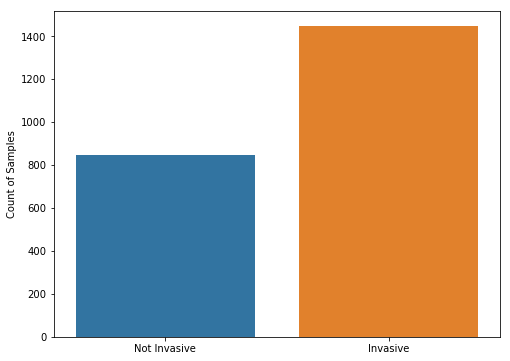

In [6]:
f, ax = plt.subplots(1,1,figsize=(8,6))
ax = sns.barplot(x=['Not Invasive','Invasive'], y=train_set.groupby(['invasive'],as_index=False).count()['name'])
ax.set(ylabel='Count of Samples')
plt.show()

### Fixing class imbalance with random image augmentation

In [10]:
train_files, train_set, train_label = load_train(master_path + os.sep + 'train')

not_inv_to_add = 601
not_inv = train_set.loc[train_set.invasive == 0,:].sample(not_inv_to_add, random_state=3)
max_file = pd.read_csv(os.path.join(os.sep, master_path, 'train_labels.csv')).name.max()

for i in range(max_file + 1, max_file + not_inv_to_add + 1):
    frompath = not_inv.iloc[i - max_file - 1, 0]
    topath = os.path.join(master_path, 'train', str(i) + '.jpg')
    read_augment_save(frompath, topath)
    train_set = train_set.append(pd.DataFrame({'name': [topath], 'invasive': [0]})[['name', 'invasive']], ignore_index=True)

In [11]:
train_set.to_pickle(os.path.join(master_path, 'train_set.pkl'))

f, ax = plt.subplots(1,1,figsize=(8,6))
ax = sns.barplot(x=['Not Invasive','Invasive'], y=train_set.groupby(['invasive'],as_index=False).count()['name'])
ax.set(ylabel='Count of Samples')
plt.show()

### Showing some training images

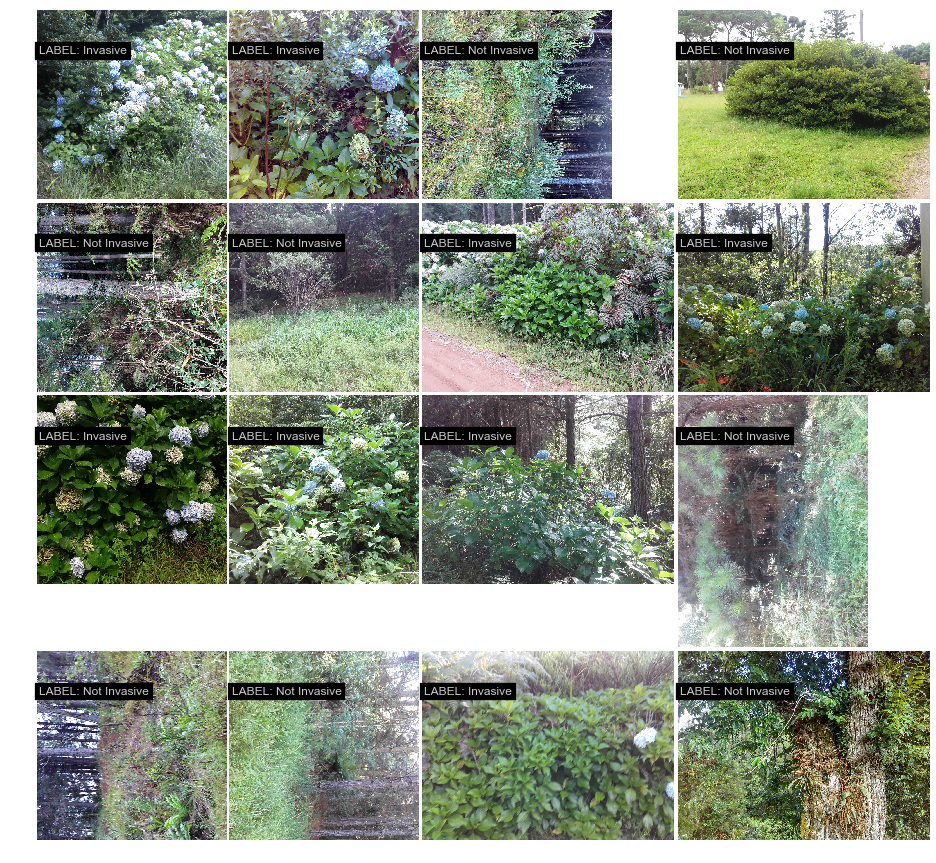

In [12]:
fig = plt.figure(1, figsize=(16, 16))
invas_dict ={0: 'Not Invasive', 1: 'Invasive'}
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
for i, (img_path, invasive)  in enumerate(train_set.sample(16).values):
    ax = grid[i]
    img = image.load_img(img_path)
    ax.imshow(img)
    ax.text(10, 200, 'LABEL: %s' % invas_dict[invasive], color='w', backgroundcolor='k', alpha=0.8)
    ax.axis('off')
plt.show()

### Showing some pre-processed training images

In [19]:
x, y = next(data_generator(train_set, 'inception', batch_size=16))

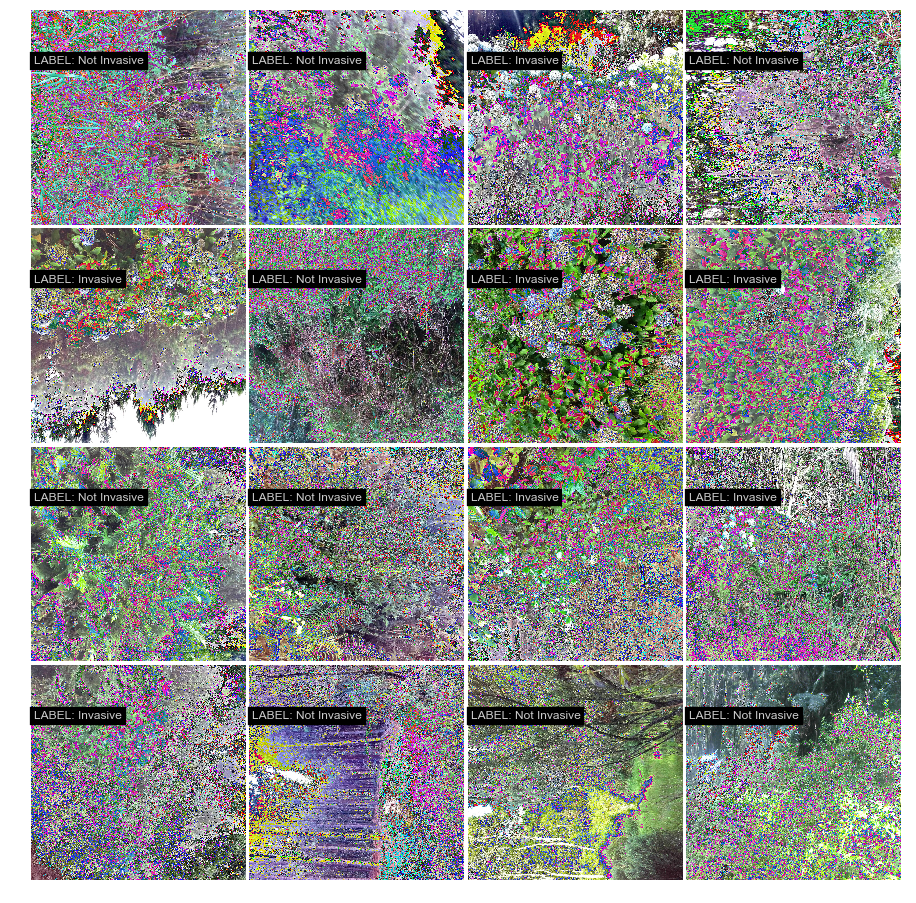

In [20]:
fig = plt.figure(1, figsize=(16, 16))
invas_dict ={0: 'Not Invasive', 1: 'Invasive'}
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
for i, (img, invasive)  in enumerate(zip(x, y)):
    ax = grid[i]
    ax.imshow(img)
    ax.text(10, 200, 'LABEL: %s' % invas_dict[invasive], color='w', backgroundcolor='k', alpha=0.8)
    ax.axis('off')
plt.show()

### Train/Test split

In [3]:
train_set = pd.read_pickle(os.path.join(master_path, 'train_set.pkl'))

X_train, X_test, y_train, y_test = train_test_split(train_set, train_set.invasive, test_size=0.15, random_state=42)

print(X_train.shape, X_test.shape)

(2461, 2) (435, 2)


### The two main pre-trained models we will be working with

In [4]:
res = get_model('resnet50', img_dim=(300,300,3))
res.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 300, 3)       12        
_________________________________________________________________
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,773
Trainable params: 23,536,647
Non-trainable params: 53,126
___________________________________________________________

In [5]:
incept = get_model('inception', img_dim=(300,300,3))
incept.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 300, 300, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,845
Trainable params: 21,770,407
Non-trainable params: 34,438
___________________________________________________________

## Transfer Learning with 5-fold-CV

In [8]:
batch_size = 8
size = (300, 300)
img_dim = (300, 300, 3)
epochs = 30
kf = KFold(n_splits=5, shuffle=True, random_state=3)

scores_res_v = []
scores_incep_v = []
scores_res_t = []
scores_incep_t = []

x = X_train
y = X_train.invasive

for i, (train_index, test_index) in enumerate(kf.split(x)):
    
    x_train = x.iloc[train_index]; x_valid = x.iloc[test_index]
    y_train = y.iloc[train_index]; y_valid = y.iloc[test_index]

    train_steps = len(x_train) / batch_size
    valid_steps = len(x_valid) / batch_size
    
    res = get_model('resnet50', img_dim=img_dim)
    incep = get_model('inception', img_dim=img_dim)
    
    early = EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4)
    reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=1, verbose=1, min_lr=1e-7)
    
    checkincept = ModelCheckpoint(filepath=os.path.join(master_path, 'inception.fold_' + str(i) + '.hdf5'), verbose=1,save_best_only=True, 
                                 save_weights_only=True, mode='auto')
    checkres = ModelCheckpoint(filepath=os.path.join(master_path, 'resnet.fold_' + str(i) + '.hdf5'), verbose=1,save_best_only=True, 
                               save_weights_only=True, mode='auto')    
    
    res.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics = ['accuracy'])
    print('Fitting ResNet Fold ' + str(i))
    res.fit_generator(data_generator(x_train, 'resnet50', size=size, batch_size=batch_size), 
                    train_steps, epochs=epochs, verbose=2, 
                    validation_data=data_generator(x_valid, 'resnet50', size=size, batch_size=batch_size), 
                    validation_steps=valid_steps, callbacks=[early, reducelr, checkres])
    with open(os.path.join(master_path, 'resnet.history.fold_' + str(i) + '.pickle'), 'wb') as handle:
        pickle.dump(res.history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    incep.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics = ['accuracy'])
    print('Fitting Inception Fold ' + str(i))
    incep.fit_generator(data_generator(x_train, 'inception', size=size, batch_size=batch_size), 
                        train_steps, epochs=epochs, verbose=2, 
                        validation_data=data_generator(x_valid, 'inception', size=size, batch_size=batch_size), 
                        validation_steps=valid_steps, callbacks=[early, reducelr, checkincept])
    with open(os.path.join(master_path, 'inception.history.fold_' + str(i) + '.pickle'), 'wb') as handle:
        pickle.dump(incep.history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    res.load_weights(filepath=os.path.join(master_path, 'resnet.fold_' + str(i) + '.hdf5'))
    incep.load_weights(filepath=os.path.join(master_path, 'inception.fold_' + str(i) + '.hdf5'))
    
    preds_valid_res = res.predict_generator(generator=data_generator(x_valid, 'resnet50', size=size, batch_size=batch_size),
                                            steps=valid_steps, verbose=0)[:, 0]

    preds_train_res = res.predict_generator(generator=data_generator(x_train, 'resnet50', size=size, batch_size=batch_size),
                                            steps=train_steps, verbose=0)[:, 0]

    preds_valid_incep = incep.predict_generator(generator=data_generator(x_valid, 'inception', size=size, batch_size=batch_size),
                                            steps=valid_steps, verbose=0)[:, 0]

    preds_train_incep = incep.predict_generator(generator=data_generator(x_train, 'inception', size=size, batch_size=batch_size),
                                            steps=train_steps, verbose=0)[:, 0]
        
    scores_res_v.append(metrics.accuracy_score(y_valid, np.where(preds_valid_res > 0.5, 1, 0)))
    scores_incep_v.append(metrics.accuracy_score(y_valid, np.where(preds_valid_incep > 0.5, 1, 0)))
    scores_res_t.append(metrics.accuracy_score(y_train, np.where(preds_train_res > 0.5, 1, 0)))
    scores_incep_t.append(metrics.accuracy_score(y_train, np.where(preds_train_incep > 0.5, 1, 0)))
    
to_be_saved = [scores_res_v, scores_incep_v, scores_res_t, scores_incep_t]

with open(os.path.join(master_path, 'scores.pickle'), 'wb') as handle:
        pickle.dump(to_be_saved, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting ResNet Fold 0
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.15619, saving model to /home/paperspace/Invasive/resnet.fold_0.hdf5
 - 155s - loss: 0.2565 - acc: 0.9050 - val_loss: 0.1562 - val_acc: 0.9533
Epoch 2/30

Epoch 00002: val_loss improved from 0.15619 to 0.11835, saving model to /home/paperspace/Invasive/resnet.fold_0.hdf5
 - 130s - loss: 0.1432 - acc: 0.9543 - val_loss: 0.1184 - val_acc: 0.9655
Epoch 3/30

Epoch 00003: val_loss improved from 0.11835 to 0.08123, saving model to /home/paperspace/Invasive/resnet.fold_0.hdf5
 - 130s - loss: 0.1094 - acc: 0.9634 - val_loss: 0.0812 - val_acc: 0.9757
Epoch 4/30

Epoch 00004: val_loss did not improve
 - 129s - loss: 0.0602 - acc: 0.9802 - val_loss: 0.1926 - val_acc: 0.9513
Epoch 5/30

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00005: val_loss did not improve
 - 133s - loss: 0.0550 - acc: 0.9832 - val_loss: 0.1050 - val_acc: 0.9716
Epoch 6/30

Epoch 00006: val_loss did not im

### Visualizing results...

In [7]:
with open(os.path.join(master_path, 'scores.pickle'), 'rb') as handle:
    scores = pickle.load(handle)

scores_res_v, scores_incep_v, scores_res_t, scores_incep_t = scores

res_d = pd.DataFrame()
incept_d = pd.DataFrame()

for i in range(5):
    with open(os.path.join(master_path, 'resnet.history.fold_' + str(i) + '.pickle'), 'rb') as handle:
        d = pickle.load(handle)
    new_res_d = pd.DataFrame.from_dict(d)
    new_res_d.rename(index=int, columns={"acc": "train_acc", "loss": "train_loss"}, inplace=True)
    new_res_d.columns = [col + '_fold_' + str(i) for col in new_res_d.columns]
    res_d = res_d.join(new_res_d, how='outer')
    
    with open(os.path.join(master_path, 'inception.history.fold_' + str(i) + '.pickle'), 'rb') as handle:
        d = pickle.load(handle)
    new_incept_d = pd.DataFrame.from_dict(d)
    new_incept_d.rename(index=int, columns={"acc": "train_acc", "loss": "train_loss"}, inplace=True)
    new_incept_d.columns = [col + '_fold_' + str(i) for col in new_incept_d.columns]
    incept_d = incept_d.join(new_incept_d, how='outer')
    
res_d.reset_index(inplace=True)
res_d.rename(index=int, columns={"index": "epoch"}, inplace=True)
res_d.sort_values(by=['epoch'], inplace=True)
incept_d.reset_index(inplace=True)
incept_d.rename(index=int, columns={"index": "epoch"}, inplace=True)
incept_d.sort_values(by=['epoch'], inplace=True)

incep_sc = pd.DataFrame({'Train Accuracy': scores_incep_t, 'Validation Accuracy': scores_incep_v, 'fold': np.arange(5)})
res_sc = pd.DataFrame({'Train Accuracy': scores_res_t, 'Validation Accuracy': scores_res_v, 'fold': np.arange(5)})

### ... for Inception V3

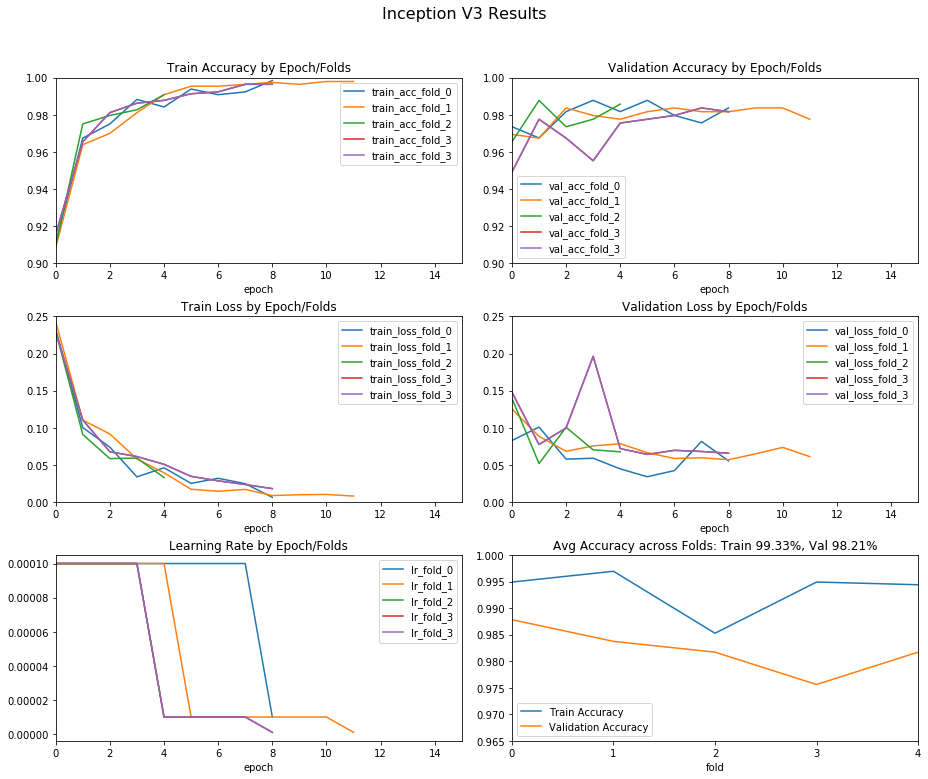

In [34]:
t_acc = incep_sc['Train Accuracy'].mean() * 100
v_acc = incep_sc['Validation Accuracy'].mean() * 100

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13,11))
fig.suptitle("Inception V3 Results", fontsize=16)

incept_d.plot(ax=axes[0, 0], x='epoch', title='Train Accuracy by Epoch/Folds',
              y=['train_acc_fold_0', 'train_acc_fold_1', 'train_acc_fold_2', 'train_acc_fold_3', 'train_acc_fold_3'])
axes[0, 0].set_ylim([0.9,1])
incept_d.plot(ax=axes[0, 1], x='epoch', title='Validation Accuracy by Epoch/Folds',
              y=['val_acc_fold_0', 'val_acc_fold_1', 'val_acc_fold_2', 'val_acc_fold_3', 'val_acc_fold_3'])
axes[0, 1].set_ylim([0.9,1])
incept_d.plot(ax=axes[1, 0], x='epoch', title='Train Loss by Epoch/Folds',
              y=['train_loss_fold_0', 'train_loss_fold_1', 'train_loss_fold_2', 'train_loss_fold_3', 'train_loss_fold_3'])
axes[1, 0].set_ylim([0.00,0.25])
incept_d.plot(ax=axes[1, 1], x='epoch', title='Validation Loss by Epoch/Folds',
              y=['val_loss_fold_0', 'val_loss_fold_1', 'val_loss_fold_2', 'val_loss_fold_3', 'val_loss_fold_3'])
axes[1, 1].set_ylim([0.00,0.25])
incept_d.plot(ax=axes[2, 0], x='epoch', title='Learning Rate by Epoch/Folds',
              y=['lr_fold_0', 'lr_fold_1', 'lr_fold_2', 'lr_fold_3', 'lr_fold_3'])
axes[2, 1].set_ylim([0.965,1.0])
incep_sc.plot(ax=axes[2, 1], x='fold', title='Avg Accuracy across Folds: Train %.2f%%, Val %.2f%%' % (t_acc, v_acc), xticks=np.arange(5))

plt.tight_layout()
fig.subplots_adjust(top=0.89)
plt.show()

### ... and for ResNet50

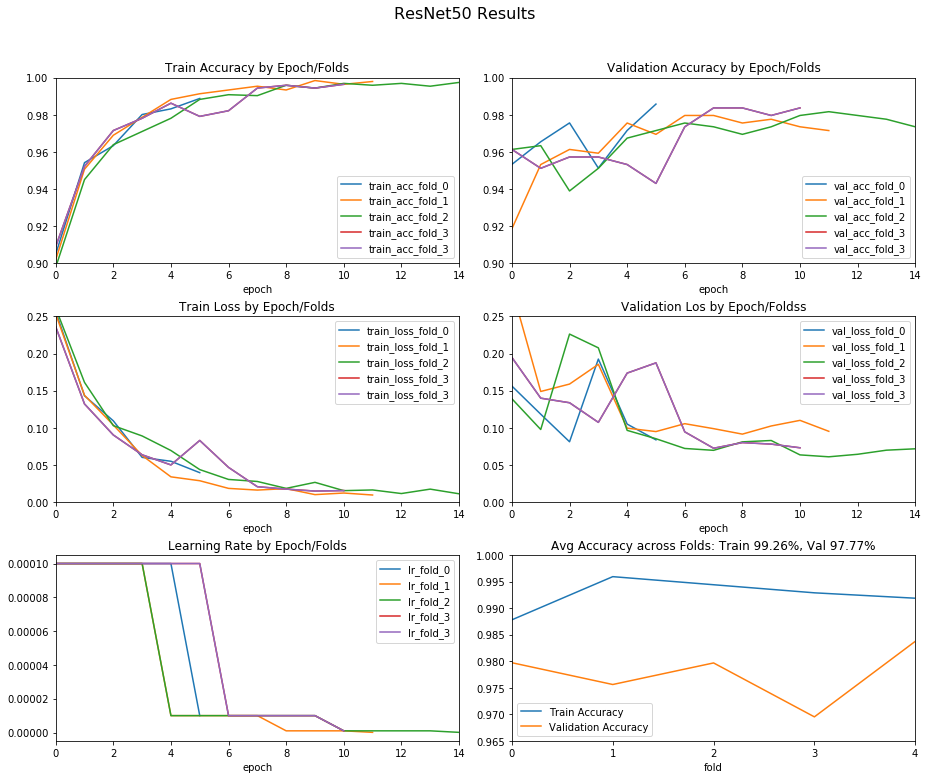

In [33]:
t_acc = res_sc['Train Accuracy'].mean() * 100
v_acc = res_sc['Validation Accuracy'].mean() * 100

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13,11))
fig.suptitle("ResNet50 Results", fontsize=16)

res_d.plot(ax=axes[0, 0], x='epoch', title='Train Accuracy by Epoch/Folds',
              y=['train_acc_fold_0', 'train_acc_fold_1', 'train_acc_fold_2', 'train_acc_fold_3', 'train_acc_fold_3'])
axes[0, 0].set_ylim([0.9,1.0])
res_d.plot(ax=axes[0, 1], x='epoch', title='Validation Accuracy by Epoch/Folds',
              y=['val_acc_fold_0', 'val_acc_fold_1', 'val_acc_fold_2', 'val_acc_fold_3', 'val_acc_fold_3'])
axes[0, 1].set_ylim([0.9,1.0])
res_d.plot(ax=axes[1, 0], x='epoch', title='Train Loss by Epoch/Folds',
              y=['train_loss_fold_0', 'train_loss_fold_1', 'train_loss_fold_2', 'train_loss_fold_3', 'train_loss_fold_3'])
axes[1, 0].set_ylim([0.00,0.25])
res_d.plot(ax=axes[1, 1], x='epoch', title='Validation Los by Epoch/Foldss',
              y=['val_loss_fold_0', 'val_loss_fold_1', 'val_loss_fold_2', 'val_loss_fold_3', 'val_loss_fold_3'])
axes[1, 1].set_ylim([0.00,0.25])
res_d.plot(ax=axes[2, 0], x='epoch', title='Learning Rate by Epoch/Folds',
              y=['lr_fold_0', 'lr_fold_1', 'lr_fold_2', 'lr_fold_3', 'lr_fold_3'])
res_sc.plot(ax=axes[2, 1], x='fold', title='Avg Accuracy across Folds: Train %.2f%%, Val %.2f%%' % (t_acc, v_acc), xticks=np.arange(5))
axes[2, 1].set_ylim([0.965,1.0])

plt.tight_layout()
fig.subplots_adjust(top=0.89)
plt.show()

## Predicting on the Test Set

In [9]:
size = (300, 300)
img_dim = (300, 300, 3)
final = {name: [] for name in X_test.name.values}

for i in range(5):
    print('Loading and predicting with Models Fold ' + str(i))
    res = get_model('resnet50', img_dim=img_dim)
    incep = get_model('inception', img_dim=img_dim)  
        
    res.load_weights(filepath=os.path.join(master_path, 'resnet.fold_' + str(i) + '.hdf5'))
    incep.load_weights(filepath=os.path.join(master_path, 'inception.fold_' + str(i) + '.hdf5'))
    
    for name in X_test.name.values:
        preprocessing_function = preprocess_input_resnet50
        img = prepare_image(name, size, preprocessing_function)
        img = np.expand_dims(img, axis=0)
        pred_res = res.predict(img)
        final[name].append(pred_res)
            
        preprocessing_function = preprocess_input_inception
        img = prepare_image(name, size, preprocessing_function)
        img = np.expand_dims(img, axis=0)
        pred_incep = incep.predict(img)
        final[name].append(pred_incep)

Loading and predicting with Models Fold 0
Loading and predicting with Models Fold 1
Loading and predicting with Models Fold 2
Loading and predicting with Models Fold 3
Loading and predicting with Models Fold 4


In [43]:
final_average = {k: [np.array(v).mean()] for k, v in final.items()}

test_proba = pd.DataFrame.from_dict(final_average, orient='index').reset_index()
test_proba.rename(index=int, columns={"index": "name", 0: "invasive_proba"}, inplace=True)

test = X_test.merge(test_proba, on='name')
test['prediction'] = np.where(test.invasive_proba > 0.5, 1, 0)
test.head()

name  invasive  invasive_proba  \
0   /home/paperspace/Invasive/train/142.jpg         0        0.011241   
1  /home/paperspace/Invasive/train/2477.jpg         0        0.000811   
2  /home/paperspace/Invasive/train/1751.jpg         1        0.999922   
3  /home/paperspace/Invasive/train/1710.jpg         0        0.001321   
4  /home/paperspace/Invasive/train/1926.jpg         0        0.000899   

   prediction  
0           0  
1           0  
2           1  
3           0  
4           0

### And the Test Set accuracy is...

In [48]:
print('Test Set Accuracy (averaged across Inception V3 and ResNet50 5 Folds): %.2f%%' 
      % (metrics.accuracy_score(test.invasive, test.prediction)*100))

Test Set Accuracy (averaged across Inception V3 and ResNet50 5 Folds): 98.85%


## VGG16 grad-CAM attention maps. What is the NN focusing on?

### Defining a VGG16 model...

In [76]:
m = VGG16(weights='imagenet', include_top=True)
j = [i for i, layer in enumerate(m.layers) if 'flatten' in layer.name][-1]
x = m.layers[j].output
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input=m.input, output=x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


### ...retraining it from scratch...

In [80]:
batch_size = 8
size = (224, 224)
epochs = 30
kf = KFold(n_splits=5, shuffle=True, random_state=3)

x = X_train
y = X_train.invasive

for i, (train_index, test_index) in enumerate(kf.split(x)):
    
    x_train = x.iloc[train_index]; x_valid = x.iloc[test_index]
    y_train = y.iloc[train_index]; y_valid = y.iloc[test_index]

    train_steps = len(x_train) / batch_size
    valid_steps = len(x_valid) / batch_size
    
    early = EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4)
    reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=1, verbose=1, min_lr=1e-7)
    checkincept = ModelCheckpoint(filepath=os.path.join(master_path, 'vis.hdf5'), verbose=1,save_best_only=True, 
                                 save_weights_only=True, mode='auto')
        
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics = ['accuracy'])
    model.fit_generator(data_generator(x_train, 'vgg', size=size, batch_size=batch_size), 
                    train_steps, epochs=epochs, verbose=2, 
                    validation_data=data_generator(x_valid, 'vgg', size=size, batch_size=batch_size), 
                    validation_steps=valid_steps, callbacks=[early, reducelr, checkincept])
    break
    
model.load_weights(os.path.join(master_path, 'vis.hdf5'))

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.33954, saving model to /home/paperspace/Invasive/vis.hdf5
 - 148s - loss: 0.4510 - acc: 0.7901 - val_loss: 0.3395 - val_acc: 0.8600
Epoch 2/30

Epoch 00002: val_loss did not improve
 - 101s - loss: 0.3473 - acc: 0.8674 - val_loss: 2.4906 - val_acc: 0.5801
Epoch 3/30

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00003: val_loss did not improve
 - 109s - loss: 0.3039 - acc: 0.8806 - val_loss: 0.8059 - val_acc: 0.8337
Epoch 4/30

Epoch 00004: val_loss improved from 0.33954 to 0.21896, saving model to /home/paperspace/Invasive/vis.hdf5
 - 101s - loss: 0.2474 - acc: 0.9131 - val_loss: 0.2190 - val_acc: 0.9148
Epoch 5/30

Epoch 00005: val_loss improved from 0.21896 to 0.17527, saving model to /home/paperspace/Invasive/vis.hdf5
 - 101s - loss: 0.2330 - acc: 0.9157 - val_loss: 0.1753 - val_acc: 0.9331
Epoch 6/30

Epoch 00006: val_loss improved from 0.17527 to 0.14505, saving model to /home/papers

### ...picking 2 random invasive images...

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


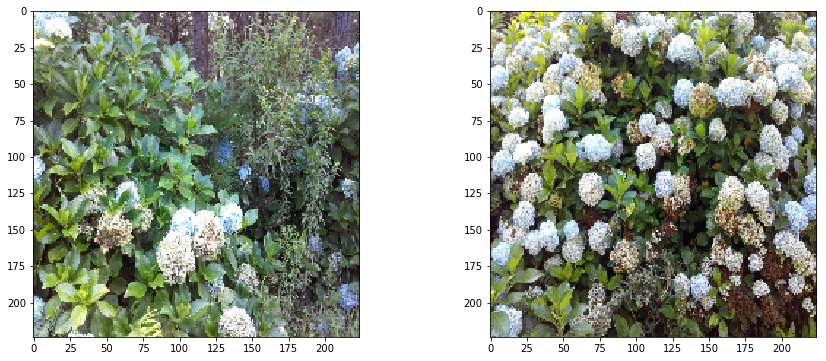

In [77]:
from vis.utils import utils
plt.rcParams['figure.figsize'] = (15, 6)
t = X_test.loc[X_test.invasive == 1, 'name'].sample(2).values

img1 = utils.load_img(t[0], target_size=(224, 224))
img2 = utils.load_img(t[1], target_size=(224, 224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

plt.show()

### ...and visualizing attention maps!

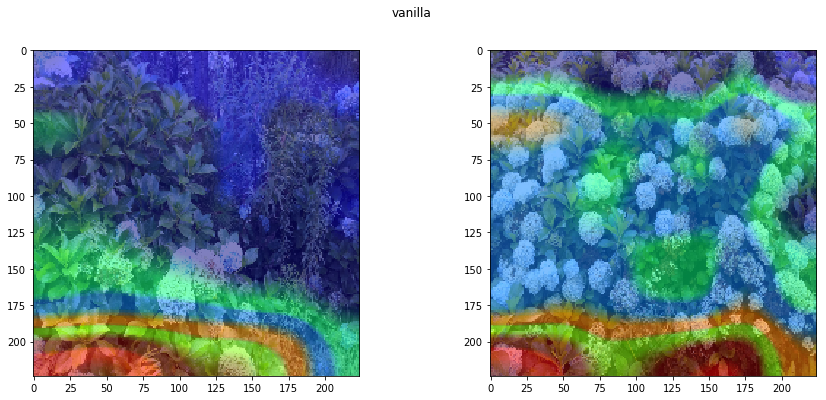

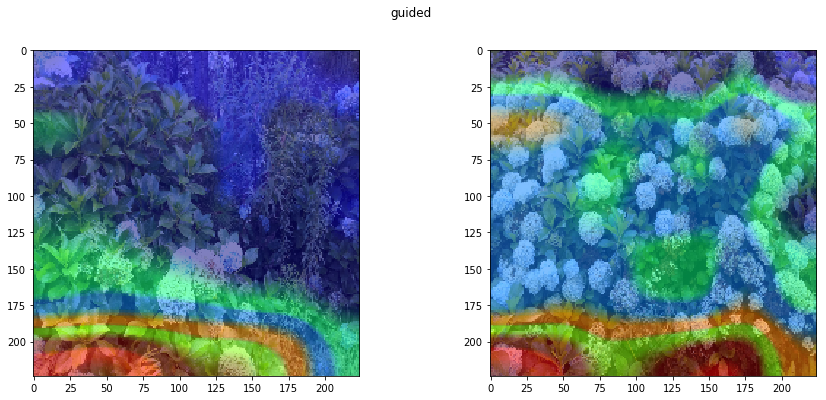

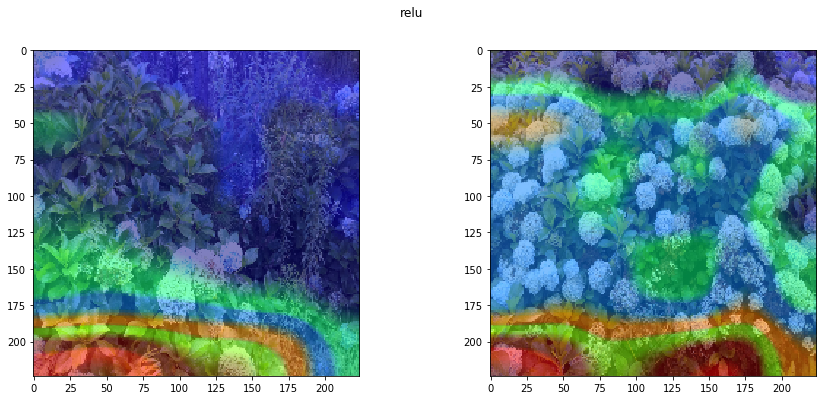

In [104]:
from vis.visualization import visualize_cam
import matplotlib.cm as cm
from vis.visualization import visualize_saliency, overlay

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_cam(model, layer_idx=19, filter_indices=1,
                              penultimate_layer_idx=18,
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap[:,:,:,0], img))